In [5]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs, Predictive

from jax import random
import jax
import jax.numpy as jnp

import arviz as az
import matplotlib.pyplot as plt

In [6]:
import skbio 
import numpy as np
from helper import custom_put_along_axis

## Preprocessing 

In [7]:
def seq_mapping(seq, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    mapped = []
    for base in seq:
            mapped.append(alphabet.find(base))
    return jnp.array(mapped)

def fasta2ref(fref_in, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    for seq in skbio.io.read(fref_in, format='fasta'):
        ref = seq_mapping(str(seq), alphabet)
    #print('reference ', str(seq))
    return ref

def fasta2reads(freads_in, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    reads_mapped = []
    #print('reads')
    for seq in skbio.io.read(freads_in, format='fasta'):
        #print(str(seq))
        reads_mapped.append(seq_mapping(str(seq), alphabet))
    return jnp.array(reads_mapped)

## Input

In [9]:
# --- 1. Example ----

reference = jnp.array([0])
reads = jnp.array([[0], [1], [1], [1], [0], [1], [0], [1]])

alphabet_length =2

input_data = reference, reads, alphabet_length

# --- 2. Example ----
fref_in='../../../test_data/super_small_ex2/ref.fasta'
freads_in='../../../test_data/super_small_ex2/seqs.fasta'

alphabet ='ACGT-'
alphabet_length = len(alphabet) # size alphabet

# Coding scheme
# 0:A, 1:C, 2:G, 3:T 4:-, 5:N

reference = fasta2ref(fref_in, alphabet)
reads = fasta2reads(freads_in, alphabet)


input_data = reference, reads, alphabet_length

cluster_num = 10

In [10]:
# import models
from ipynb.fs.full.models_NumPyro import model_infiniteSBP, model_finiteDPM, model_finiteDPM_extended

## Model inference with MCMC (HMC + Gibbs)   
#### - Use of HMC for continuous and Gibbs sampling for discrete variables.

In [11]:
rng_key = jax.random.PRNGKey(0)
num_samples = 20000
num_warmup = int(num_samples / 2)

model = model_finiteDPM

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(
    DiscreteHMCGibbs(kernel),
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=1
)
mcmc.run(rng_key, input_data)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:43<00:00, 696.78it/s, 7 steps of size 4.56e-01. acc. prob=0.82]


In [12]:
mcmc.print_summary()


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
cluster_assignments[0,0]      2.96      1.63      4.00      0.00      4.00      3.67      1.54
cluster_assignments[1,0]      1.92      1.28      2.00      0.00      4.00     40.98      1.08
cluster_assignments[2,0]      1.92      1.28      2.00      0.00      4.00     40.94      1.09
cluster_assignments[3,0]      1.91      1.28      2.00      0.00      4.00     40.82      1.08
cluster_assignments[4,0]      1.88      1.26      2.00      0.00      4.00     54.36      1.06
cluster_assignments[5,0]      2.96      1.63      4.00      0.00      4.00      3.67      1.54
cluster_assignments[6,0]      2.96      1.63      4.00      0.00      4.00      3.67      1.54
cluster_assignments[7,0]      2.96      1.63      4.00      0.00      4.00      3.67      1.54
cluster_assignments[8,0]      2.96      1.63      4.00      0.00      4.00      3.67      1.54
      cluster_weights[0]      0.20      0.18     

In [13]:
posterior_samples = mcmc.get_samples()

In [14]:
# Make sure to infer_discrete
# Predictive obtained by running model conditioned on latent samples from posterior_samples p(theta | data)

posterior_predictive = Predictive(model, posterior_samples, infer_discrete=True)
posterior_predictions = posterior_predictive(rng_key, input_data=input_data)

In [16]:
# computes expected log predictive density at each data point

from numpyro.infer.util import log_likelihood

log_likelihood = log_likelihood(model, posterior_samples, input_data=input_data )
#log_likelihood['obs']

In [17]:
inference_data = az.from_numpyro(
    posterior=mcmc,
    posterior_predictive=posterior_predictions,
)
display(inference_data)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

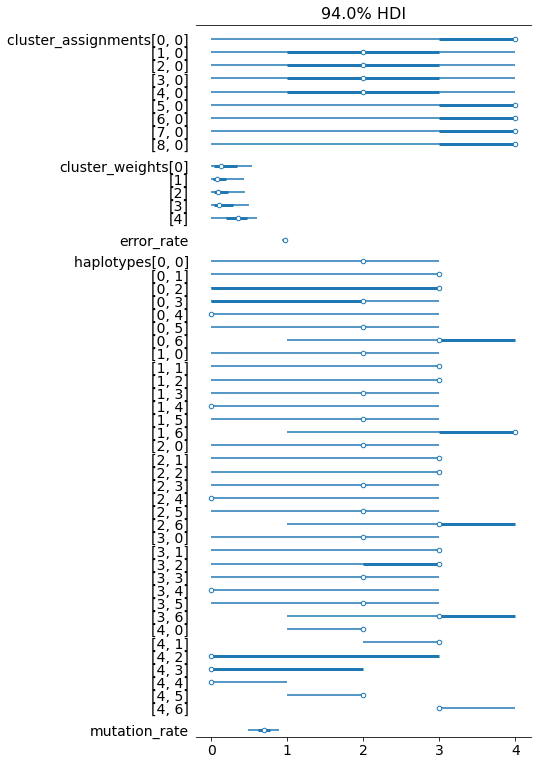

In [18]:
az.plot_forest(inference_data, combined=True)

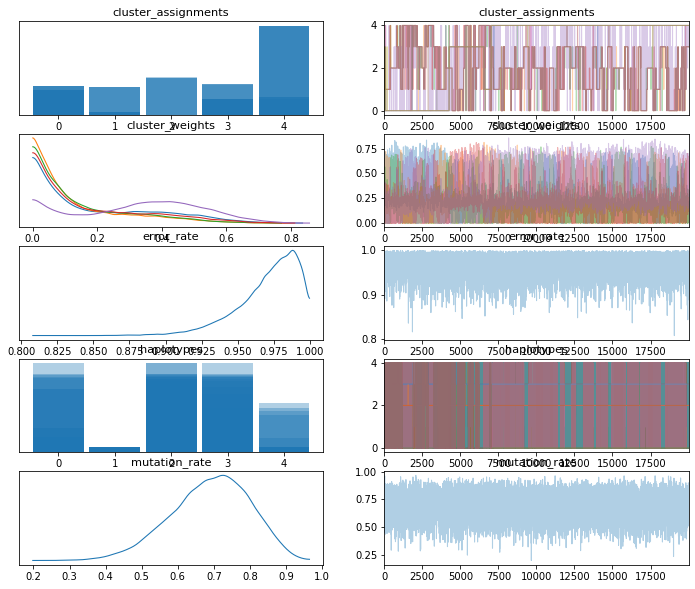

In [19]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True)
plt.show()

## Model inference with variational approximations
#### - Using mean field approximation

In [ ]:
from numpyro.distributions import constraints

def guide_infiniteSBP(input_data):
    reference, read_data, alphabet_length = input_data
    
    max_cluster_num_guess = 10  # guess for maximum number of clusters

    # parameters
    read_count = read_data.shape[0]
    genome_length = reference.shape[0]
    alphabet_length = alphabet_length
    
    # define rates
    q_mutation_rate = numpyro.sample("mutation_rate", dist.Beta(1, 1))
    q_error_rate = numpyro.sample("error_rate", dist.Beta(1, 1))

    # create matrix of rates
    mutation_rate_matrix = jnp.full(
        (genome_length, alphabet_length), 1
    )
    
    with numpyro.plate("beta_plate", max_cluster_num_guess - 1):
        q_beta = numpyro.sample("beta", dist.Beta(1, 1.1))
    print('q_beta ', q_beta.shape)
    q_cluster_weights = numpyro.sample(
        "cluster_weights", dist.Dirichlet(jnp.ones(max_cluster_num_guess))
    )
    print(q_cluster_weights.shape)
    
    genome_axis = numpyro.plate("genome_axis", genome_length, dim=-1)
    with numpyro.plate("haplotype_axis", max_cluster_num_guess, dim=-2):
        with genome_axis:
            q_haplotypes = numpyro.sample(
                "haplotypes", dist.Categorical(mutation_rate_matrix)
            )  # cluster centers
            
    print(q_haplotypes.shape)

    phi = numpyro.param('phi', jnp.full((read_count, max_cluster_num_guess), 1/max_cluster_num_guess), constraints=constraints.simplex)
    print('phi' , phi.shape)
    with numpyro.plate("read_axis", read_count, dim=-2):
        q_cluster_assignments = numpyro.sample(
            "cluster_assignments", dist.Categorical(phi)
        )
    print(q_cluster_assignments.shape)

In [ ]:
from numpyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, Predictive, init_to_median
from numpyro.infer.autoguide import AutoGuide

In [ ]:
model = model_finiteDPM
guide = guide_infiniteSBP

In [ ]:
optimizer = numpyro.optim.Adam(step_size=0.0005)

rng_key = jax.random.PRNGKey(0)


# setup the inference algorithm
svi = SVI(
    model=model,
    guide=guide,
    optim=optimizer,
    loss=Trace_ELBO()
)

# Run
svi_result = svi.run(rng_key,5000,input_data)


## Postprocessing

In [20]:
import scipy

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

In [21]:
def convert_h_to_seq(h, alphabet):
    '''
    Convert numeric representation to DNA-seq representation. 
    '''
    seq = [alphabet[int(h[k])] for k in range(h.shape[0])]
    return ''.join(seq)

In [24]:
def corrected_reads_to_fasta(posterior_samples, model, input_data, rng_key, list_read_ids, fname_output_corr, alphabet,last_x_samples=100):

    # TODO: Do we want to cut posterior samples?
    reads = input_data[1]

    # only consider the last {last_x_samples} samples to summarize results
    cluster_assignments = posterior_samples['cluster_assignments'][-last_x_samples:,:,:]
    haplotypes = posterior_samples['haplotypes'][-last_x_samples:,:,:]

    average_cluster_assignment = scipy.stats.mode(cluster_assignments, axis=0)[0][0]
    average_haplotypes = scipy.stats.mode(haplotypes, axis=0)[0][0]

    # computes empirical posterior from posterior_samples p(theta | data)
    posterior_predictive = Predictive(model, posterior_samples, infer_discrete=True)
    posterior_predictions = posterior_predictive(rng_key, input_data=input_data)['obs'][-last_x_samples:,:,:]
    posterior = [(posterior_predictions[:,n,:]==reads[n][:]).all(-1).sum() / last_x_samples for n in range(len(list_read_ids))]

    records = []
    for n ,read_id in enumerate(list_read_ids):
        hap_seq = convert_h_to_seq(average_haplotypes[average_cluster_assignment[n]][0], alphabet)
        header = '|posterior=' + str(posterior[n])
        records.append(SeqRecord(Seq(hap_seq), id=read_id, description=header))

    SeqIO.write(records, fname_output_corr, "fasta")

In [42]:
def haplotypes_to_fasta(posterior_samples, model, input_data, rng_key, fname_output_corr, alphabet, last_x_samples=100):
    genome_length = posterior_samples['haplotypes'].shape[2]
    alphabet_length = len(alphabet)

    # only consider the last {last_x_samples} samples to summarize results
    cluster_assignments = posterior_samples['cluster_assignments'][-last_x_samples:,:,:]
    haplotypes = posterior_samples['haplotypes'][-last_x_samples:,:,:]

    # number of reads assigned to each haplo
    hap_ids, ave_reads = np.unique(cluster_assignments, return_counts=True)

    # collapse haplotypes into unique set
    average_haplotypes = scipy.stats.mode(haplotypes, axis=0)[0][0]
    unique_haplotypes = np.unique(average_haplotypes, axis=0)
    idx_collapsed_haplotypes = [np.where(np.all(average_haplotypes==unique_hap,axis=1)) for unique_hap in unique_haplotypes]
    idx_collapsed_haplotypes = [np.intersect1d(idx_col,hap_ids) for idx_col in idx_collapsed_haplotypes]
    # map idx_collapsed_haplotypes to hap_ids order
    outer = []
    for idx_collapsed in idx_collapsed_haplotypes:
        outer.append([np.argwhere(hap_ids==i)[0][0] for i in idx_collapsed])
    mapped_idx_collapsed_haplotypes = outer

    # collapse number of average reads to unique haplotypes
    ave_reads = np.array([np.sum(ave_reads[idx_hap]) for idx_hap in mapped_idx_collapsed_haplotypes])
    ave_reads = ave_reads / last_x_samples

    # empirical posteriors of haplotypes (collapsed like in ave_reads computation)
    posterior_predictive = Predictive(model, 
                                      posterior_samples, 
                                      infer_discrete=True, 
                                      return_sites=['haplotypes']
                                     )
    posterior_predictions = posterior_predictive(rng_key, 
                                                 input_data=input_data
                                                )['haplotypes'][-last_x_samples:,:,:]
    posterior = [(posterior_predictions[:,hap_ids[idx_hap],:]==average_haplotypes[hap_ids[idx_hap]][:]).all(-1).sum() / last_x_samples for idx_hap in mapped_idx_collapsed_haplotypes]

    # write to fasta
    records = []
    for k in range(unique_haplotypes.shape[0]):
        head = ' | posterior='+str(posterior[k])+' ave_reads='+str(ave_reads[k])
        seq = convert_h_to_seq(unique_haplotypes[k], alphabet)
        records.append(SeqRecord(Seq(seq), id='haplotype'+str(k), description=head))
    SeqIO.write(records, fname_output_corr, "fasta")


------

In [43]:
haplotypes_to_fasta(posterior_samples,
                    model, 
                    input_data, 
                    rng_key, 
                    '/Users/lfuhrmann/Downloads/haplos.fasta', 
                    alphabet, 
                    last_x_samples=100)

[2 3 4]
[array([4]), array([3]), array([2])]
[[2], [1], [0]]


In [35]:
scipy.stats.mode(posterior_samples['haplotypes'], axis=0)[0][0]

NameError: name 'scipy' is not defined

In [ ]:
scipy.stats.mode(posterior_samples['haplotypes'][-100:,:,:], axis=0)[0][0]

In [ ]:
# inferred haplotypes
scipy.stats.mode(posterior_samples['haplotypes'][-50:,:,:], axis=0)[0][0]

In [ ]:
scipy.stats.mode(posterior_samples['cluster_assignments'][-4:,:,:], axis=0)[0][0]

In [ ]:
scipy.stats.mode(posterior_samples['cluster_assignments'][-100:,:,:], axis=0)[0][0]

In [ ]:
# inferred cluster assignments
scipy.stats.mode(posterior_samples['cluster_assignments'], axis=0)[0][0]

In [ ]:
# inferred no-mutation rate
np.mean(posterior_samples['mutation_rate'])

In [ ]:
# inferred no-error rate
np.mean(posterior_samples['error_rate'])